In [ ]:
 pip install QuantLib

# ***CONNECTING TO GOOGLE DRIVE***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***LIBRARIES***

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import torch.nn.functional as Func
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import pandas as pd
import os
from scipy.stats import norm
from scipy.optimize import minimize
import QuantLib as ql
from datetime import datetime

#torch.manual_seed(123)
np.random.seed(123)

# ***MODEL***

In [ ]:
# Define the ABU activation function for the SABR PDE
class SinSoftplusActivation(nn.Module):
    def forward(self, input):
        new_act_f = 0.005*torch.sin(input) + 1*torch.nn.functional.softplus(input) + 0*torch.nn.functional.tanh(input) + 0.00*torch.nn.functional.gelu(input)
        return new_act_f

In [ ]:
class Alternative_FCN(nn.Module):
    def __init__(self):
        super(Alternative_FCN, self).__init__()
        self.bn1 = nn.BatchNorm1d(3)
        self.fc1 = nn.Linear(3, 200)
        self.act1 = SinSoftplusActivation()
        self.bn2 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 200)
        self.act2 = SinSoftplusActivation()
        self.bn3 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, 200)
        self.act3 = SinSoftplusActivation()
        self.bn4 = nn.BatchNorm1d(200)
        self.fc4 = nn.Linear(200, 200)
        self.act4 = SinSoftplusActivation()
        self.bn5 = nn.BatchNorm1d(200)
        self.fc5 = nn.Linear(200, 200)
        self.act5 = SinSoftplusActivation()
        self.bn6 = nn.BatchNorm1d(200)
        self.fc6 = nn.Linear(200, 1)


    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        x = self.fc6(x)
        return x

# ***RANDOM DATASET GENERATION FOR PDE AND OTHER CONDITIONS***

Total points: 2190
Interior: 365 points (S∈[0.6, 149.9])
S=0 boundary: 365 points (σ∈[0.0, 0.5])
σ=0 boundary: 365 points (S∈[0.8, 149.7])


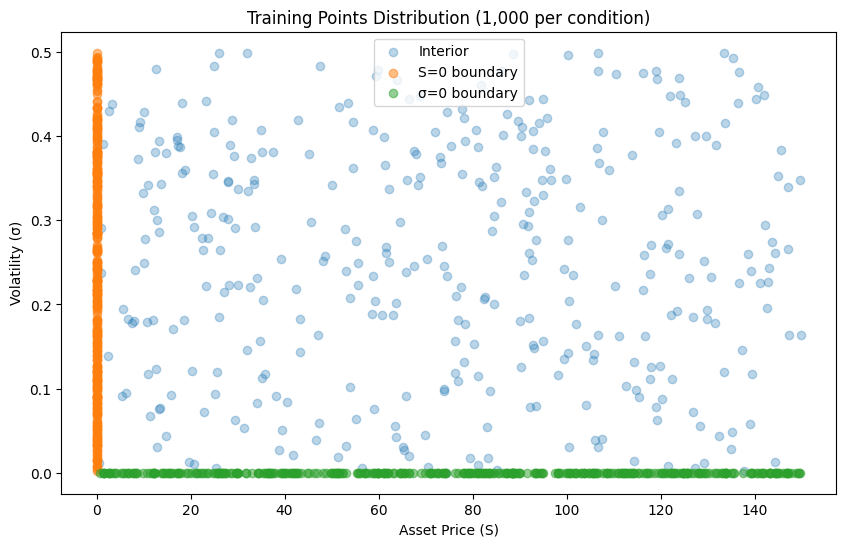

In [ ]:
def generate_points_per_condition(N=1000, S_min=0.0, S_max=150.0,
                                sigma_min=0.0, sigma_max=0.5, t=1.0):
    """
    Generates 1,000 random points for each:
    - Interior domain
    - S=0 boundary
    - S=S_max boundary
    - σ=0 boundary
    - σ=σ_max boundary
    - Initial condition (t=T)
    """
    # --- Interior points (S, σ, t all random) ---
    S_int = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma_int = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_int = torch.rand(N, 1) * t
    interior = torch.cat([S_int, sigma_int, t_int], dim=1)

    # --- Boundary: S=0 (σ and t random) ---
    S0 = torch.zeros(N, 1)
    sigma_S0 = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_S0 = torch.rand(N, 1) * t
    bd_S0 = torch.cat([S0, sigma_S0, t_S0], dim=1)

    # --- Boundary: S=S_max (σ and t random) ---
    Smax = torch.ones(N, 1) * S_max
    sigma_Smax = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_Smax = torch.rand(N, 1) * t
    bd_Smax = torch.cat([Smax, sigma_Smax, t_Smax], dim=1)

    # --- Boundary: σ=0 (S and t random) ---
    S_sigma0 = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma0 = torch.zeros(N, 1)
    t_sigma0 = torch.rand(N, 1) * t
    bd_sigma0 = torch.cat([S_sigma0, sigma0, t_sigma0], dim=1)

    # --- Boundary: σ=σ_max (S and t random) ---
    S_sigmamax = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigmamax = torch.ones(N, 1) * sigma_max
    t_sigmamax = torch.rand(N, 1) * t
    bd_sigmamax = torch.cat([S_sigmamax, sigmamax, t_sigmamax], dim=1)

    # --- Initial condition: t=T (S and σ random) ---
    S_initial = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma_initial = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_initial = torch.zeros(N, 1)
    initial = torch.cat([S_initial, sigma_initial, t_initial], dim=1)

    # Combine all (total points = 6*N)
    all_points = torch.cat([
        interior, bd_S0, bd_Smax, bd_sigma0, bd_sigmamax, initial
    ], dim=0).requires_grad_(True)

    return {
        'interior': interior,
        'bd_S0': bd_S0,
        'bd_Smax': bd_Smax,
        'bd_sigma0': bd_sigma0,
        'bd_sigmamax': bd_sigmamax,
        'initial': initial,
        'all': all_points
    }

# Generate 1,000 points per condition
data = generate_points_per_condition(N=365)

# Verify
print(f"Total points: {len(data['all'])}")
print(f"Interior: {len(data['interior'])} points (S∈[{data['interior'][:,0].min():.1f}, {data['interior'][:,0].max():.1f}])")
print(f"S=0 boundary: {len(data['bd_S0'])} points (σ∈[{data['bd_S0'][:,1].min():.1f}, {data['bd_S0'][:,1].max():.1f}])")
print(f"σ=0 boundary: {len(data['bd_sigma0'])} points (S∈[{data['bd_sigma0'][:,0].min():.1f}, {data['bd_sigma0'][:,0].max():.1f}])")

# Plot S-σ distribution
plt.figure(figsize=(10, 6))
plt.scatter(data['interior'][:,0], data['interior'][:,1], label='Interior', alpha=0.3)
plt.scatter(data['bd_S0'][:,0], data['bd_S0'][:,1], label='S=0 boundary', alpha=0.5)
plt.scatter(data['bd_sigma0'][:,0], data['bd_sigma0'][:,1], label='σ=0 boundary', alpha=0.5)
plt.xlabel("Asset Price (S)"), plt.ylabel("Volatility (σ)")
plt.title("Training Points Distribution (1,000 per condition)")
plt.legend()
plt.show()

# ***PDE AND PINN CONDITIONS***

In [ ]:
# Define a function to compute the partial derivatives needed for the Heston PDE
def compute_derivatives_heston(model, S, v, t):
    inputs = torch.cat([S, v, t], dim=1)
    # Compute C (option price)
    C = model(inputs)

    # Compute partial derivatives using autograd
    C_S = torch.autograd.grad(C, S, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_v = torch.autograd.grad(C, v, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_t = torch.autograd.grad(C, t, grad_outputs=torch.ones_like(C), create_graph=True)[0]

    C_SS = torch.autograd.grad(C_S, S, grad_outputs=torch.ones_like(C_S), create_graph=True)[0]
    C_vv = torch.autograd.grad(C_v, v, grad_outputs=torch.ones_like(C_v), create_graph=True)[0]
    C_Sv = torch.autograd.grad(C_S, v, grad_outputs=torch.ones_like(C_S), create_graph=True)[0]

    return C, C_S, C_v, C_t, C_SS, C_Sv, C_vv

    # Define the Heston PDE
def heston_pde(model, S, v, t, kappa, theta, sigma, rho, r):
    C, C_S, C_v, C_t, C_SS, C_Sv, C_vv = compute_derivatives_heston(model, S, v, t)
    rho = torch.tensor(rho, dtype=torch.float32, device=S.device)
    sigma = torch.tensor(sigma, dtype=torch.float32, device=S.device)
    kappa = torch.tensor(kappa, dtype=torch.float32, device=S.device)
    theta = torch.tensor(theta, dtype=torch.float32, device=S.device)
    r = torch.tensor(r, dtype=torch.float32, device=S.device)
    # Compute the terms of the Heston PDE
    term1 = C_t
    term2 = 0.5 * v * S**2 * C_SS
    term3 = rho * sigma * v * S * C_Sv
    term4 = 0.5 * sigma**2 * v * C_vv
    term5 = r * S * C_S
    term6 = kappa * (theta - v) * C_v
    term7 = -r * C

    # Heston PDE that equals zero
    residual = term1 + term2 + term3 + term4 + term5 + term6 + term7
    return residual

# Define boundary conditions
def Smin_conditions(model, inputs_S_min):
    # Boundary condition for S = S_min
    boundary_S_min = model(inputs_S_min)  # V(t, F_min, alpha) = 0
    boundary_S_min = torch.mean(boundary_S_min**2)

    return boundary_S_min

# Define boundary conditions
def Smax_conditions2(model,  inputs_S_max):
    # Boundary condition for S = S_max
    fSmax = inputs_S_max[:, 0].requires_grad_(True).reshape(-1, 1)
    V_S_max = model(inputs_S_max)
    V_S_max_dx = torch.autograd.grad(V_S_max, inputs_S_max, torch.ones_like(V_S_max), create_graph=True)[0]
    dVdS = V_S_max_dx[:, 0].reshape(-1, 1)
    boundary_S_max = dVdS - 1
    boundary_S_max = torch.mean(boundary_S_max**2)
    return boundary_S_max

    # Define boundary conditions
def Smax_conditions(model,  inputs_S_max):
    # Boundary condition for S = S_max
    fSmax = inputs_S_max[:, 0].requires_grad_(True).reshape(-1, 1)
    V_S_max = model(inputs_S_max)
    V_S_max_dx = torch.autograd.grad(V_S_max, inputs_S_max, torch.ones_like(V_S_max), create_graph=True)[0]
    V_S_max_d2x = torch.autograd.grad(V_S_max_dx, inputs_S_max, torch.ones_like(V_S_max_dx), create_graph=True)[0]
    dSmaxd2x = V_S_max_d2x[:, 0].reshape(-1, 1)
    boundary_S_max = torch.mean(dSmaxd2x**2)
    return boundary_S_max

# Define boundary conditions
def v0_conditions(model, inputs_v_min, K, r):
    # Boundary condition for alpha = 0
    Vmin_S = inputs_v_min[:, 0].reshape(-1, 1)
    Vmin_t = inputs_v_min[:, 2].reshape(-1, 1)
    V_v_min = model(inputs_v_min)
    V_v_min_dt = torch.autograd.grad(V_v_min, inputs_v_min, torch.ones_like(V_v_min), create_graph=True)[0]
    dVmindt = V_v_min_dt[:, 2].reshape(-1, 1)
    #boundary_alpha_min = V_alpha_min_dt
    boundary_v_min = V_v_min - torch.maximum(Vmin_S - K*torch.exp(-r*Vmin_t), torch.tensor(0.0))
    boundary_v_min = torch.mean(boundary_v_min**2)

    return boundary_v_min
# Define boundary conditions
def Vmax_conditions(model, inputs_v_max):
    # Boundary condition for alpha = 0
    Vmax_S = inputs_v_max[:, 0].reshape(-1, 1)
    V_v_max = model(inputs_v_max)
    boundary_v_max = V_v_max - Vmax_S
    boundary_v_max = torch.mean(boundary_v_max**2)

    return boundary_v_max

def IC_european_call(S, K):
    val = torch.maximum(S - K, torch.tensor(0.0))
    return val.view(-1, 1).requires_grad_(True)

# ***CALIBRATION***

In [ ]:
# Heston model calibration function
def heston_calibration_error(params, market_prices, strike_prices, maturities, spots, risk_free_rate=0.0007, dividend_rate=0.0):
    """
    Calculate the squared errors between market and Heston model prices.

    params: [v0, kappa, theta, sigma, rho]
    """
    v0, kappa, theta, sigma, rho = params

    # Set up QuantLib calendar and day counter
    calendar = ql.NullCalendar()
    day_count = ql.Actual365Fixed()

    calculation_date = ql.Date().from_date(datetime.now().date())
    ql.Settings.instance().evaluationDate = calculation_date

    errors = []

    for i, (K, T, market_price, spot) in enumerate(zip(strike_prices, maturities, market_prices, spots)):
        # Skip if maturity is zero or negative
        if T <= 0:
            continue

        # Create option payoff and exercise
        payoff = ql.PlainVanillaPayoff(ql.Option.Call, float(K))
        exercise = ql.EuropeanExercise(calculation_date + ql.Period(int(T*252), ql.Days))

        # Create Heston process
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, day_count))
        dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_rate, day_count))

        heston_process = ql.HestonProcess(flat_ts, dividend_ts, spot_handle,
                                         v0, kappa, theta, sigma, rho)

        # Create Heston model and engine
        heston_model = ql.HestonModel(heston_process)
        engine = ql.AnalyticHestonEngine(heston_model)

        # Price the option
        option = ql.VanillaOption(payoff, exercise)
        option.setPricingEngine(engine)

        try:
            heston_price = option.NPV()
        except:
            heston_price = 0  # Return 0 if pricing fails

        # Calculate squared error
        error = (heston_price - market_price)**2
        errors.append(error)

    # Return mean squared error
    return np.mean(errors)

In [ ]:
def sabr_volatility(alpha, beta, rho, nu, F, K, T):
    """ Computes the SABR model implied volatility using Hagan's formula """
    if F == K:  # ATM case
        FK_beta = F**(1 - beta)
        vol = alpha / FK_beta * (1 + (((1 - beta) ** 2) / 24 * (alpha**2 / FK_beta**2) +
                                     (1 / 4) * (rho * beta * nu * alpha / FK_beta) +
                                     ((2 - 3 * rho**2) / 24) * (nu**2)) * T)
    else:
        z = (nu / alpha) * (F * K) ** ((1 - beta) / 2) * np.log(F / K)
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
        FK_beta = (F * K) ** ((1 - beta) / 2)
        term1 = (1 + ((((1-beta)**2)/24)*((alpha**2)/FK_beta**2) +
                     (1 / (4*FK_beta)) * (rho * beta * nu * alpha) +
                     ((2 - 3 * rho**2) / 24) * (nu**2)) * T)
        term2 = (1 + ((((1 - beta) ** 2) / 24) * ((np.log(F/K)) ** 2)) +
                 ((((1 - beta) ** 4) / 1920) * ((np.log(F/K)) ** 4)))
        vol = (alpha / FK_beta) * (z / x_z) * term1 / term2
    return vol

# Loss function to minimize
def sabr_loss(params, F, strikes, T, market_vols):
    alpha, beta, rho, nu = params
    model_vols = np.array([sabr_volatility(alpha, beta, rho, nu, F, K, T) for K in strikes])
    return np.sum((model_vols - market_vols) ** 2)

# ***ANALYTICAL BS - MONTE CARLO***

In [ ]:
# ANALYTICAL BS OPTION PRICE

def black_scholes_option_price(S, K, T, r, sigma, option_type='call'):

    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T+0.00000001))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        # Calculate the price of a European call option
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        # Calculate the price of a European put option
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return option_price

# MONTE CARLO OPTION PRICE

def sabr_european_call_mc(S0_array, sigma0_array, T_array, K, r,
                          beta, nu, rho, N, M, confidence=0.95):

    S0_array = np.asarray(S0_array).flatten()
    sigma0_array = np.asarray(sigma0_array).flatten()
    T_array = np.asarray(T_array).flatten()

    n_samples = len(S0_array)
    prices = np.zeros(n_samples)
    conf_intervals = []

    z_score = norm.ppf(1 - (1 - confidence) / 2)

    for i in range(n_samples):
        S0 = S0_array[i]
        alpha0 = sigma0_array[i]
        T = T_array[i]
        dt = T / N
        sqrt_dt = np.sqrt(dt)

        # Initialize arrays
        S = np.zeros((M, N+1))
        alpha = np.zeros((M, N+1))
        S[:, 0] = S0
        alpha[:, 0] = alpha0

        for t in range(N):
            z1 = np.random.randn(M)
            z2 = np.random.randn(M)
            dW1 = z1
            dW2 = rho * z1 + np.sqrt(1 - rho**2) * z2

            alpha[:, t+1] = alpha[:, t] + nu * alpha[:, t] * dW2 * sqrt_dt
            S[:, t] = np.maximum(S[:, t], 1e-12)
            sigma_S = alpha[:, t] * (S[:, t]**(beta))
            mu_S = r * S[:, t]
            S[:, t+1] = S[:, t] + mu_S * dt + sigma_S * dW1 * sqrt_dt
            #S[:, t+1] = S[:, t]  + sigma_S * dW1 * sqrt_dt

        # Call option payoff
        payoffs = np.maximum(S[:, -1] - K, 0)
        discounted = np.exp(-r * T) * payoffs

        mean_price = np.mean(discounted)
        prices[i] = mean_price

    return prices


# ***CALLING REAL DATASET***

In [ ]:
# Load all sheets in the Excel file
excel_file = "/content/drive/MyDrive/Bitirme_real_dataset/european_options.xlsx"
sheet_names = pd.ExcelFile(excel_file).sheet_names

results_MC_df = pd.DataFrame(columns=["Sheet", "Heston Model MSE", "Heston Model MAPE"])

prediction_df = pd.DataFrame()

output_dir = "/content/drive/MyDrive/Bitirme_real_dataset/new/Heston/real"
os.makedirs(output_dir, exist_ok=True)

# ***TRAINING***

In [ ]:
for sheet_name in sheet_names:
    print(f"Processing sheet: {sheet_name}")
    # Load data for the current sheet
    df = pd.read_excel(excel_file, sheet_name=sheet_name)

    # Verileri işleyin
    F = df['close'].values  # SPOT PRICE
    spot_price = df['close'].iloc[0]
    sigma = df['implied_volatility'].values
    K = df['strike'].values
    market_prices = df['Option_mid'].values
    time = df['Remaining_day'].values / 252

    df_no_zeros = df[df["Option_mid"] != 0]

    F_nozero = df['close'].values  # SPOT PRICE
    spot_price_nozero = df['close'].iloc[0]
    sigma_nozero = df['implied_volatility'].values
    K_nozero = df['strike'].values
    market_prices_nozero = df['Option_mid'].values
    time_nozero = df['Remaining_day'].values / 252

    print( "F: ", F)
    print( "F no zero: ", F_nozero)
    print( "spot price no zero: ", spot_price_nozero)

    # Initial parameter guesses for heston
    initial_params_heston = [sigma_nozero[0]**2, 2.0, 0.04, 0.1, -0.7] # v0 - initial variance, kappa - mean reversion speed, theta - long-term variance, sigma - vol of vol, rho - correlation

     # Bounds for heston parameters (v0 > 0, kappa > 0, theta > 0, sigma > 0, -1 <= rho <= 1)
    bounds_heston = [(0.01, 0.5), (0.1, 10.0), (0.01, 0.5), (0.01, 1.0), (-0.99, 0.99)]

    # Run calibration for heston parameters
    result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),
                                        bounds=bounds_heston, method='L-BFGS-B', options={'maxiter': 100, 'disp': True})

    # Extract calibrated heston parameters
    v0_heston, kappa, theta, sigma_heston, rho_heston = result_parameters_heston.x

    print("Optimized Heston parameters:")
    print("v0:", v0_heston)
    print("kappa:", kappa)
    print("theta:", theta)
    print("sigma_heston:", sigma_heston)
    print("rho_heston:", rho_heston)

    # Initial guess for SABR parameters
    initial_guess = [sigma[0], 1, 0.0, 0.3]

        # Optimize SABR parameters
    result_parameters = minimize(sabr_loss, initial_guess, args=(F[0], K, time[0], sigma),
                              bounds=[(0.01, 1), (0, 1), (-0.99, 0.99), (0.01, None)])

    alfa, beta, rho, nu = result_parameters.x

    print("Optimized SABR parameters:")
    print("Alpha:", alfa)
    print("Beta:", beta)
    print("Rho:", rho)
    print("Nu:", nu)

    F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1)
    sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1)

    F_min, F_max = torch.min(F_torch).item(), torch.max(F_torch).item()
    v_min, v_max = torch.min(sigma_torch).item(), torch.max(sigma_torch).item()

    r=0.0007

    lambda1, lambda2 = 1, 1

    model = Alternative_FCN()
    optimizer = torch.optim.Adam(model.parameters(),lr=2e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=200,
        min_lr=2e-5)

    best_loss = float('inf')
    save_path = 'best_model.pth'

    totallosses=[]
    Lic_list = []
    Lpde_list = []
    Lbd_list = []
    Lbd_Smax_list = []
    Lbd_Smin_list = []
    Lbd_Vmax_list = []
    Lbd_V0_list = []

# Compute model

    for i in range(1000):
        data = generate_points_per_condition(N=1000, S_min=0.0, S_max=1.2*F_max,
                                    sigma_min=0.0, sigma_max=1.1*v_max, t=1.0)

        t0 = data['initial'].clone().detach().requires_grad_(True)
        V0 = data['bd_sigma0'].clone().detach().requires_grad_(True)
        S0 = data['bd_S0'].clone().detach().requires_grad_(True)
        Smax = data['bd_Smax'].clone().detach().requires_grad_(True)
        vmax = data['bd_sigmamax'].clone().detach().requires_grad_(True)
        inputs = data['interior'].clone().detach().requires_grad_(True)
        inputs_all = data['all'].clone().detach().requires_grad_(True)


        C0 = model(t0)
        loss1 = (torch.squeeze(C0) - IC_european_call(t0[:,0].requires_grad_(True).reshape(-1, 1), K[0]))**2
        Lic = lambda1 * loss1.mean()

    # Compute the PDE residual as the loss
        residual = heston_pde(model, inputs[:,0].requires_grad_(True).reshape(-1, 1), inputs[:,1].requires_grad_(True).reshape(-1, 1), inputs[:,2].requires_grad_(True).reshape(-1, 1),  kappa, theta, sigma_heston, rho_heston, r)
        Lpde = lambda2 * torch.mean(residual**2)

        bnd_S_min = Smin_conditions(model, S0)

        bnd_S_max = Smax_conditions(model, Smax)

        bnd_v_min = v0_conditions(model, V0, K[0], r)

        bnd_v_max = Vmax_conditions(model, vmax)

        Lbd = ( 10*bnd_S_max + 0.0001*bnd_v_max + 1000000*bnd_v_min + 1*bnd_S_min )
        Lic2 = 0.0000015*Lic
        Lpde2 = Lpde
        loss = Lic2 + Lpde2 + Lbd

        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step(loss)
        optimizer.zero_grad()

        totallosses.append(loss.item())
        Lic_list.append(Lic2.item())
        Lpde_list.append(Lpde2.item())
        Lbd_list.append(Lbd.item())

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")
            print(f"Loss-1 (IC): {Lic2.item()}, Loss-2 (pde): {Lpde2.item()} , Loss-5 (bd): {Lbd.item()}")
            print("CURRENT LR:", scheduler.get_last_lr())

        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
                'iteration': i
                }, save_path)

    print("best loss: ", best_loss )

    checkpoint = torch.load("best_model.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model {checkpoint['iteration']} iterasyondan yüklendi, Loss: {checkpoint['loss']:.6f}")

    F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1)
    sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1)
    time_torch = torch.tensor(time, dtype=torch.float32, requires_grad=True).view(-1, 1)

    inputs_heston = torch.cat([F_torch, sigma_torch, time_torch], dim=1)

    C = model(inputs_heston) # PINN OPTION PRICES
    C = C.detach().numpy()

    bs_op_pr = black_scholes_option_price(F, K[0], time, r, sigma) # ANALYTICAL BS OPTION PRICES

    mc = sabr_european_call_mc(F, sigma, time, K[0], r, beta, nu, rho, N=100, M=10000, confidence=0.95) # MONTE CARLO OPTIONS PRİCES

    plt.plot(time, C, label="Heston-PINN", linestyle='dashed')
    plt.plot(time, bs_op_pr, label="Analytical BS Values")
    plt.plot(time, mc, label="Monte Carlo Values")
    plt.xlabel("Time (t)")
    plt.ylabel("Option Price (C)")
    plt.legend()
    plot_path = os.path.join(output_dir, f"{sheet_name}_option_price_plot_time.png")
    plt.savefig(plot_path)
    plt.close()
    plt.show()

    mse1 = np.mean((mc - C.ravel())**2)
    mape1 = np.mean(np.abs((mc - C.ravel()) / mc))
    print("MSE between MC and PINN:", mse1)
    print("MAPE between MC and PINN::", mape1)

    new_row = pd.DataFrame({
    "Sheet": [sheet_name],
    "Heston Model MSE": [mse1],
    "Heston Model MAPE": [mape1],
    })

    results_MC_df = pd.concat([results_MC_df, new_row], ignore_index=True)

    prediction_df[f'Heston_{sheet_name}'] = pd.Series(C.flatten())



Processing sheet: XEO
F:  [663.869995 662.330017 664.690002 663.090027 661.140015 662.23999
 667.590027 667.880005 666.349976 666.039978 666.919983 669.330017
 671.369995 673.580017 675.77002  673.969971 677.150024 676.190002
 679.840027 677.099976 674.890015 681.73999  673.77002  681.159973
 681.030029 679.679993 683.039978 682.75     683.599976 684.02002
 684.940002 683.969971 689.26001  681.950012 678.359985 683.619995
 671.75     675.900024 683.659973 682.530029 683.650024 686.52002
 693.27002  694.150024 695.820007 698.27002  700.76001  698.309998
 698.619995 702.719971 701.75     698.       696.909973 700.559998
 694.809998 700.570007 698.289978 703.73999  702.919983 704.570007
 702.169983 707.049988 700.549988 702.969971 699.48999  703.099976
 705.98999  714.73999  716.940002 715.380005 700.650024 710.099976
 700.190002 695.099976 700.820007]
F no zero:  [663.869995 662.330017 664.690002 663.090027 661.140015 662.23999
 667.590027 667.880005 666.349976 666.039978 666.919983 669.

/tmp/ipython-input-662244525.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.01
kappa: 0.8018357686817156
theta: 0.01
sigma_heston: 0.05561879887792333
rho_heston: 0.99
Optimized SABR parameters:
Alpha: 0.16391512114306103
Beta: 0.9999999584026403
Rho: -0.004711434880146214
Nu: 0.3046928300850347


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  current = float(metrics)


Iteration 0, Loss: 10468761600.0
Loss-1 (IC): 0.018049931153655052, Loss-2 (pde): 0.11936638504266739 , Loss-5 (bd): 10468761600.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 3820506880.0
Loss-1 (IC): 0.015254350379109383, Loss-2 (pde): 73.3627700805664 , Loss-5 (bd): 3820506880.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 3627879936.0
Loss-1 (IC): 0.013779880478978157, Loss-2 (pde): 1678.521240234375 , Loss-5 (bd): 3627878144.0
CURRENT LR: [0.0002]
Iteration 300, Loss: 3759337216.0
Loss-1 (IC): 0.015242933295667171, Loss-2 (pde): 1552.9124755859375 , Loss-5 (bd): 3759335680.0
CURRENT LR: [0.0002]
Iteration 400, Loss: 3145578240.0
Loss-1 (IC): 0.015416132286190987, Loss-2 (pde): 10706.861328125 , Loss-5 (bd): 3145567488.0
CURRENT LR: [0.0002]
Iteration 500, Loss: 3014743296.0
Loss-1 (IC): 0.016634687781333923, Loss-2 (pde): 5357.53076171875 , Loss-5 (bd): 3014737920.0
CURRENT LR: [0.0002]
Iteration 600, Loss: 2567259392.0
Loss-1 (IC): 0.01633433811366558, Loss-2 (pde): 10406.7373046875 , 

/tmp/ipython-input-662244525.py:208: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_MC_df = pd.concat([results_MC_df, new_row], ignore_index=True)
/tmp/ipython-input-662244525.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.022660728146950065
kappa: 1.999652872283538
theta: 0.03760951789724406
sigma_heston: 0.09831745940125704
rho_heston: -0.6998355474885308
Optimized SABR parameters:
Alpha: 0.37870372003511654
Beta: 0.9998338414020369
Rho: -0.23720622531737695
Nu: 0.7698718433798445
Iteration 0, Loss: 201837120.0
Loss-1 (IC): 0.0002863171393983066, Loss-2 (pde): 0.0008016103529371321 , Loss-5 (bd): 201837120.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 8110102.5
Loss-1 (IC): 0.00034210801823064685, Loss-2 (pde): 83.39868927001953 , Loss-5 (bd): 8110019.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 247212.265625
Loss-1 (IC): 0.0003698428045026958, Loss-2 (pde): 782.33447265625 , Loss-5 (bd): 246429.9375
CURRENT LR: [0.0002]
Iteration 300, Loss: 111606.953125
Loss-1 (IC): 0.00037707664887420833, Loss-2 (pde): 900.865478515625 , Loss-5 (bd): 110706.0859375
CURRENT LR: [0.0002]
Iteration 400, Loss: 96477.234375
Loss-1 (IC): 0.0003586345410440117, Loss-2 (pde): 882.708862304687

/tmp/ipython-input-662244525.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.01018081
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.15156709512089991
Beta: 0.9999967901358356
Rho: -0.01516995285073654
Nu: 0.34609497748622053
Iteration 0, Loss: 1800444288.0
Loss-1 (IC): 0.00310392864048481, Loss-2 (pde): 0.0031229830347001553 , Loss-5 (bd): 1800444288.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 117787560.0
Loss-1 (IC): 0.0030288342386484146, Loss-2 (pde): 26.702308654785156 , Loss-5 (bd): 117787536.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 10084440.0
Loss-1 (IC): 0.002954028081148863, Loss-2 (pde): 3688.94580078125 , Loss-5 (bd): 10080751.0
CURRENT LR: [0.0002]
Iteration 300, Loss: 378506.5625
Loss-1 (IC): 0.0033835687208920717, Loss-2 (pde): 1835.671630859375 , Loss-5 (bd): 376670.875
CURRENT LR: [0.0002]
Iteration 400, Loss: 217859.0625
Loss-1 (IC): 0.0033668428659439087, Loss-2 (pde): 1738.2618408203125 , Loss-5 (bd): 216120.796875
CURRENT LR: [0.0002]
Iteration 500, Loss: 14

/tmp/ipython-input-662244525.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.01222150024941749
kappa: 1.999755493074403
theta: 0.03136772584629667
sigma_heston: 0.09444337107127766
rho_heston: -0.6994422503590686
Optimized SABR parameters:
Alpha: 0.397185460322435
Beta: 0.9999955422288376
Rho: -0.14576196658874566
Nu: 0.4497171930050832
Iteration 0, Loss: 1795665024.0
Loss-1 (IC): 0.00263439049012959, Loss-2 (pde): 0.15282899141311646 , Loss-5 (bd): 1795665024.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 256515968.0
Loss-1 (IC): 0.0023884286638349295, Loss-2 (pde): 762.0036010742188 , Loss-5 (bd): 256515200.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 41183056.0
Loss-1 (IC): 0.0029918737709522247, Loss-2 (pde): 47574.48046875 , Loss-5 (bd): 41135480.0
CURRENT LR: [0.0002]
Iteration 300, Loss: 1994951.125
Loss-1 (IC): 0.0028466754592955112, Loss-2 (pde): 175684.75 , Loss-5 (bd): 1819266.375
CURRENT LR: [0.0002]
Iteration 400, Loss: 1027405.9375
Loss-1 (IC): 0.0033749795984476805, Loss-2 (pde): 152859.4375 , Loss-5 (bd): 874546.5


/tmp/ipython-input-662244525.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.01
kappa: 0.1
theta: 0.01
sigma_heston: 0.010000099323059274
rho_heston: 0.989999743969011
Optimized SABR parameters:
Alpha: 0.18117878405735752
Beta: 0.9999999998719092
Rho: -0.0012965441960742813
Nu: 0.3012766992482001
Iteration 0, Loss: 132456112128.0
Loss-1 (IC): 0.2676127851009369, Loss-2 (pde): 14.839289665222168 , Loss-5 (bd): 132456112128.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 66697478144.0
Loss-1 (IC): 0.2277296632528305, Loss-2 (pde): 1559.9403076171875 , Loss-5 (bd): 66697478144.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 63303454720.0
Loss-1 (IC): 0.229843407869339, Loss-2 (pde): 1919.3363037109375 , Loss-5 (bd): 63303454720.0
CURRENT LR: [0.0002]
Iteration 300, Loss: 58449813504.0
Loss-1 (IC): 0.23751607537269592, Loss-2 (pde): 2367.728515625 , Loss-5 (bd): 58449809408.0
CURRENT LR: [0.0002]
Iteration 400, Loss: 59372662784.0
Loss-1 (IC): 0.2198793590068817, Loss-2 (pde): 1993.90625 , Loss-5 (bd): 59372662784.0
CURRENT LR: [0.0001]
I

/tmp/ipython-input-662244525.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.01
kappa: 2.0042192027905856
theta: 0.01
sigma_heston: 0.031670657779664504
rho_heston: -0.6911697301957113
Optimized SABR parameters:
Alpha: 0.3153755358893661
Beta: 0.9612499265069332
Rho: 0.011606627541049862
Nu: 0.290711148756385
Iteration 0, Loss: 3224569600.0
Loss-1 (IC): 0.004596519283950329, Loss-2 (pde): 0.0017150540370494127 , Loss-5 (bd): 3224569600.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 588408896.0
Loss-1 (IC): 0.004438580945134163, Loss-2 (pde): 40.56219482421875 , Loss-5 (bd): 588408832.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 249862400.0
Loss-1 (IC): 0.004636093974113464, Loss-2 (pde): 2638.73046875 , Loss-5 (bd): 249859760.0
CURRENT LR: [0.0002]
Iteration 300, Loss: 21892900.0
Loss-1 (IC): 0.006204881239682436, Loss-2 (pde): 11320.865234375 , Loss-5 (bd): 21881580.0
CURRENT LR: [0.0002]
Iteration 400, Loss: 5559347.0
Loss-1 (IC): 0.00571351358667016, Loss-2 (pde): 7736.44580078125 , Loss-5 (bd): 5551610.5
CURRENT LR: [0.0002]
I

/tmp/ipython-input-662244525.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.035758809999999995
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.17674716434392249
Beta: 0.9109094274700095
Rho: 0.057145069130527464
Nu: 0.2958559238500854
Iteration 0, Loss: 245849899008.0
Loss-1 (IC): 0.3778645694255829, Loss-2 (pde): 0.6003046631813049 , Loss-5 (bd): 245849899008.0
CURRENT LR: [0.0002]
Iteration 100, Loss: 5786245632.0
Loss-1 (IC): 0.22886808216571808, Loss-2 (pde): 665.4525756835938 , Loss-5 (bd): 5786245120.0
CURRENT LR: [0.0002]
Iteration 200, Loss: 5444738048.0
Loss-1 (IC): 0.22696010768413544, Loss-2 (pde): 2702.55810546875 , Loss-5 (bd): 5444735488.0
CURRENT LR: [0.0002]
Iteration 300, Loss: 4683732480.0
Loss-1 (IC): 0.24328716099262238, Loss-2 (pde): 13473.263671875 , Loss-5 (bd): 4683719168.0
CURRENT LR: [0.0002]
Iteration 400, Loss: 5035406848.0
Loss-1 (IC): 0.22680369019508362, Loss-2 (pde): 8587.0087890625 , Loss-5 (bd): 5035398144.0
CURRENT LR: [0.0002]
Iteration 500, Los

/tmp/ipython-input-662244525.py:35: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result_parameters_heston = minimize(heston_calibration_error, initial_params_heston, args=(market_prices_nozero, K_nozero, time_nozero, F_nozero),


Optimized Heston parameters:
v0: 0.015876
kappa: 2.0
theta: 0.04
sigma_heston: 0.1
rho_heston: -0.7
Optimized SABR parameters:
Alpha: 0.11673556748513755
Beta: 0.8591591020385676
Rho: 0.05016560944625224
Nu: 0.29796745170723665
Iteration 0, Loss: 456155299840.0
Loss-1 (IC): 0.7175131440162659, Loss-2 (pde): 0.9860969185829163 , Loss-5 (bd): 456155299840.0
CURRENT LR: [0.0002]


# ***SAVING***

In [ ]:
# Save results to an Excel file
results_file = "/content/drive/MyDrive/Bitirme_real_dataset/new/Heston/real/MSE_MAPE_Results_analytic.xlsx"
results_MC_df.to_excel(results_file, index=False)
print(f"Results saved to {results_file}")


# Save results to an Excel file
results_file2 = "/content/drive/MyDrive/Bitirme_real_dataset/new/Heston/real/Predictions.xlsx"
prediction_df.to_excel(results_file2, index=False)
print(f"Results saved to {results_file2}")